<center><img src="img/torch.png" alt="drawing" width="300"/></center>

# Regression

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize':(6,3), 'legend.loc':"best", 'lines.linewidth':1.5, 'lines.marker':".", "image.cmap":"tab10", 'axes.prop_cycle':plt.cycler(color=plt.cm.tab10.colors), 'axes.formatter.useoffset':False, 'axes.titlesize': 12,'axes.labelsize': 10,'ytick.labelsize':8,'xtick.labelsize':8,'legend.fontsize': 10})
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchinfo import summary
from torchviz import make_dot
import torchmetrics
import mlflow
from helper_functions import train_val_loss_plot

## Linear Regression

### Data

X_train: torch.Size([40, 1]) | X_test: torch.Size([10, 1]) | y_train: torch.Size([40, 1]) | y_test: torch.Size([10, 1]) 



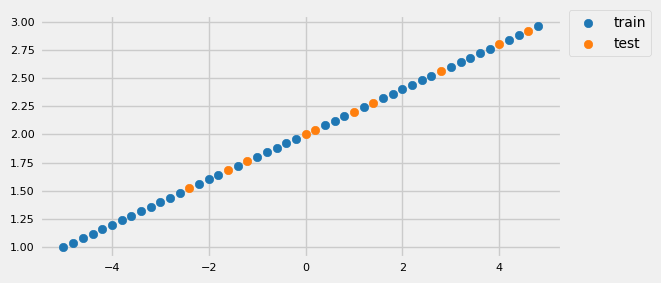

In [47]:
# Create data to experiment with
def make_data(plot=True):
    X = torch.arange(-5, 5, 0.2).unsqueeze(1)
    y = (lambda x: 0.2 * x + 2)(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} \n")
        
    if plot:
        plt.scatter(X_train, y_train, label='train')
        plt.scatter(X_test, y_test, label='test')
        plt.legend(bbox_to_anchor=(1,1.05), loc="upper left")
        plt.show()
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_data()

### Models

To fully utilize the power of the `torch.nn` module we need to understand what it’s doing. To develop this understanding, we will first train a basic linear regression model without using any features from the `torch.nn` module; we will use nothing but the basic PyTorch tensor operations. 

#### From Scratch

PyTorch builds models mainly within classes, so let's build the `LinearRegressionModel` class.

In [48]:
# Build the model explicitly by including the linear regression equation
class LinearRegressionModelV0(nn.Module): # Inherit from subclass nn.Module which is the base class containing all building blocks for NN
    
    def __init__(self):
        super().__init__() # Inherit all attributes and methods from nn.Module
       
        # Initialise model parameters (weights and biases) to be used in computations
        self.weights = nn.Parameter(torch.randn(
            1, # Shape of random tensor
            requires_grad=True, # Gradients need to be computed for this tensor for forward propagation
            dtype=torch.float)) # By default PyTorch need parameters to be of type float
        self.bias = nn.Parameter(torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float))
    
    # Forward method (any nn.Module subsclases require this) which defines the forward computation of the model
    # It will automatically be called by the `__call__()` method upon instantiation so no need to explicitly call it
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # linear equation for linear regression
        
# Instantiate model
linear_regression_0 = LinearRegressionModelV0()

In [49]:
# Get model summary
summary(linear_regression_0, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
LinearRegressionModelV0 (LinearRegressionModelV0)  [40, 1]         [40, 1]         2               True
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

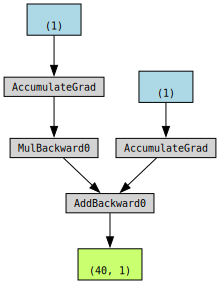

In [50]:
# Get model plot
make_dot(linear_regression_0(X_train))

In [51]:
# Get model parameters
linear_regression_0.state_dict()

OrderedDict([('weights', tensor([-0.8293])), ('bias', tensor([-1.6137]))])

#### Linear Layer

Although `linear_regression_0` model works just fine, in reality there is no need to build everything from scratch since the `nn.Linear` layer of Pytorch already implements the linear regression equation. We will now incrementally add these features from `torch.nn`. As we will see, these modules make building an NN model extremely easy.

In [60]:
# Build the model using the nn.Linear
class LinearRegressionModelV1(nn.Module):
    
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
       
        # Build linear layer (also called dense or fully connected layer) by using nn.Linear from nn.Module
        self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
linear_regression_1 = LinearRegressionModelV1(in_features=1, out_features=1)

In [61]:
summary(linear_regression_1, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape     Output Shape    Param #         Trainable
LinearRegressionModelV1 (LinearRegressionModelV1)  [40, 1]         [40, 1]         --              True
├─Linear (linear_layer)                            [40, 1]         [40, 1]         2               True
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

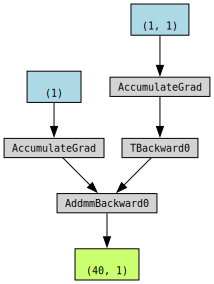

In [63]:
make_dot(linear_regression_1(X_train))

In [55]:
linear_regression_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.1789]])),
             ('linear_layer.bias', tensor([0.5078]))])

>A few words on the `requires_grad` argument.
>
>PyTorch tensors can remember where they come from, in terms of the operations and parent tensors that originated them, and they can automatically provide the chain of derivatives of such operations with respect to their inputs. This means that given a forward expression, no matter how nested, PyTorch will automatically provide the gradient of that expression with respect to its input parameters.
>
>The `requires_grad` argument is telling PyTorch to track the entire family tree of tensors resulting from operations on params. In other words, any tensor that will have params as an ancestor will have access to the chain of functions that were called to get from params to that tensor. In case these functions are differentiable (and most PyTorch tensor operations will be), the value of the derivative will be automatically populated as a grad attribute of the params tensor.
>
>In general, all PyTorch tensors have an attribute named `grad`, which by default it’s `None`. All we have to do to populate it is to start with a tensor with `requires_grad` set to `True`. That way, the `grad` attribute of params will contain the derivatives of the loss with respect to each element of params.

### Train & Validate Model

Now we will build a function in order to train and validate the model. In order to train the model first we have to  and an optimizer. Then we need to build a training loop:

```
Loop through the data (epochs) and do:
    Step 1. Forward Propagation (defined with `forward` method in model class).
    Step 2. Calculate Train Loss (need to define a loss function).
    Step 3. Optimizer Zero Grad (calling `loss.backward()` in the next step will lead derivatives to accumulate. We need to zero the gradient explicitly after using it for parameter updates).
    Step 4. Backpropagation (`loss.backward()` uses the `requires_grad` to compute the gradients).
    Step 5. Optimizer Step (performs gradient descent - updates the model's parameters with respect to the gradients)
```

Finally we will validate the model with a metric.

In [56]:
# Build train function
def train(
    experiment_name: str,
    model: nn.Module,
    data: (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor),
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    metrics: list,
    epochs: int,
    description: str = None
):  
    # Set experiment tracking
    mlflow.set_experiment(experiment_name=experiment_name)
    
    # Start tracking run
    with mlflow.start_run(
        run_name = f"{model.__class__.__name__} {datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}", # Include both model name and date of run
        description=description
    ):

        # Unpack data
        X_train, X_test, y_train, y_test = data

        # Pass data through model for a number of epochs
        for epoch in range(epochs):
            
            # Create metrics dictionary to temporarily save metrics
            metrics_dict = {}   

            ### TRAINING ###
            # Put model in training mode (default state of a model) which sets all parameters that require gradients to require gradients
            model.train()

            # Step 1: Forward Propagation
            # Pass data through model which will run the `forward()` method of class, automatically triggered in `__call__()`
            y_pred = model(X_train)

            # Step 2: Calculate Train Loss
            train_loss = loss_fn(y_pred, y_train)

            # Step 3: Optimzer Zero Grad
            # Zero optimizer gradients to start fresh each forward pass (they accumulate over every iteration) 
            optimizer.zero_grad()

            # Step 4: Backpropagation
            # Compute gradient of every parameter with `requires_grad=True`
            train_loss.backward()

            # Step 5: Optimizer Step 
            # Update model's parameters with respect to the gradients calculated by `loss.backward()`
            optimizer.step()
            
            # Calculate training metrics
            for metric in metrics:
                metrics_dict[f"train_{metric.__class__.__name__}"] = metric(y_pred, y_train)
                
            ### VALIDATING ###
            # put the model in evaluation mode which turns off functionality used for training
            model.eval()

            # turn on `torch.inference_mode()` context manager to disable functionality such as gradient tracking not needed for inference
            with torch.inference_mode():

                # pass the test data through the model (this will call the model's implemented `forward()` method)
                y_pred = model(X_test)

                # calculate the validation loss
                validation_loss = loss_fn(y_pred, y_test)
                
                # calculate validation metrics
                for metric in metrics:
                    metrics_dict[f"validation_{metric.__class__.__name__}"] = metric(y_pred, y_test)
                    
            # Display info on how model is doing during training
            if epoch % (epochs/10) == 0:
                print(f"Epoch: {epoch} | Train Loss: {train_loss:.3f} | Validation Loss: {validation_loss:.3f}")
            
            ### LOGGING ###
            # Log train and validation loss
            mlflow.log_metrics({
                "train_loss": train_loss.item(),
                "validation_loss": validation_loss.item()
            }, step=epoch)

            # Log train and validation metrics
            for metric_name, metric_value in metrics_dict.items():
                mlflow.log_metric(key=metric_name, value=metric_value, step=epoch)

        # Log model
        mlflow.pytorch.log_model(model, "model")
        
        # Log hyperparameters
        mlflow.log_params({
            "epochs": epochs,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0]["lr"]
        })

        # Plot and log train validation loss plot
        fig = train_val_loss_plot(run_id= mlflow.active_run().info.run_id, plot=True)
        mlflow.log_figure(fig, "plots/train_validation_loss_curves.png")

Epoch: 0 | Train Loss: 4.687 | Validation Loss: 1.587
Epoch: 20 | Train Loss: 0.583 | Validation Loss: 0.601
Epoch: 40 | Train Loss: 0.263 | Validation Loss: 0.278
Epoch: 60 | Train Loss: 0.119 | Validation Loss: 0.125
Epoch: 80 | Train Loss: 0.053 | Validation Loss: 0.057
Epoch: 100 | Train Loss: 0.024 | Validation Loss: 0.026
Epoch: 120 | Train Loss: 0.011 | Validation Loss: 0.012
Epoch: 140 | Train Loss: 0.005 | Validation Loss: 0.005
Epoch: 160 | Train Loss: 0.002 | Validation Loss: 0.002
Epoch: 180 | Train Loss: 0.001 | Validation Loss: 0.001


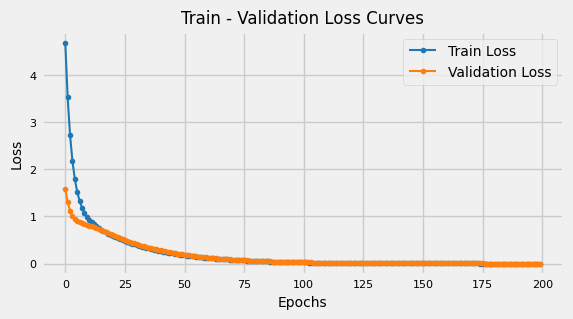

In [57]:
# Random seed for reproducibility
torch.manual_seed(42) 

# Initiate model
model = LinearRegressionModelV1(in_features=X_train.shape[1], out_features=1)

# Setup loss function
loss_fn = nn.MSELoss()

# Setup optimizer by defining which parameters should the optimizer optimize
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

# Define metrics to track
metrics = [torchmetrics.MeanSquaredError()]

# Train model
train(experiment_name="linear_regression",
      model=model, 
      data=(X_train, X_test, y_train, y_test), 
      loss_fn=loss_fn , 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=200)

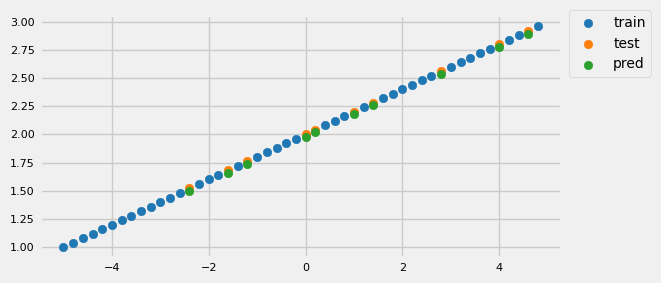

In [16]:
# Plot predictions
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.scatter(X_test, model(X_test).detach().numpy(), label='pred')
plt.legend(bbox_to_anchor=(1,1.05), loc="upper left")
plt.show()

### Application: Insurance Charges

In [17]:
def download_data():
    return pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv?raw=true")

df = download_data()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [64]:
def make_data(df):
    
    # Categorical encoding
    df = pd.get_dummies(df, ["sex", "smoker", "region"], dtype=int)
    
    # Create features and targets tensors
    X = torch.Tensor(df.drop("charges", axis=1).to_numpy())
    y = torch.Tensor(df.charges.to_numpy())

    # Split train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fix shapes
    y_train, y_test = y_train.unsqueeze(1), y_test.unsqueeze(1)
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} \n")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_data(df=df)

X_train: torch.Size([1070, 11]) | X_test: torch.Size([268, 11]) | y_train: torch.Size([1070, 1]) | y_test: torch.Size([268, 1]) 



In [65]:
class LinearModel(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
model = LinearModel(in_features=X_train.shape[1], out_features=1)

In [66]:
summary(model, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
LinearModel (LinearModel)                [1070, 11]      [1070, 1]       --              True
├─Linear (linear_layer)                  [1070, 11]      [1070, 1]       12              True
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.06

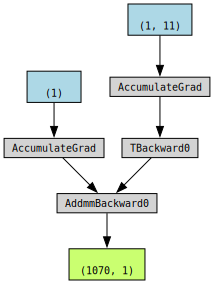

In [69]:
make_dot(model(X_train))

Epoch: 0 | Train Loss: 13329.157 | Validation Loss: 12926.699
Epoch: 100 | Train Loss: 10884.403 | Validation Loss: 10504.970
Epoch: 200 | Train Loss: 9100.570 | Validation Loss: 8790.653
Epoch: 300 | Train Loss: 8045.015 | Validation Loss: 7899.521
Epoch: 400 | Train Loss: 7549.274 | Validation Loss: 7566.482
Epoch: 500 | Train Loss: 7383.863 | Validation Loss: 7449.214
Epoch: 600 | Train Loss: 7324.209 | Validation Loss: 7405.370
Epoch: 700 | Train Loss: 7295.815 | Validation Loss: 7382.813
Epoch: 800 | Train Loss: 7280.084 | Validation Loss: 7366.405
Epoch: 900 | Train Loss: 7267.781 | Validation Loss: 7350.292


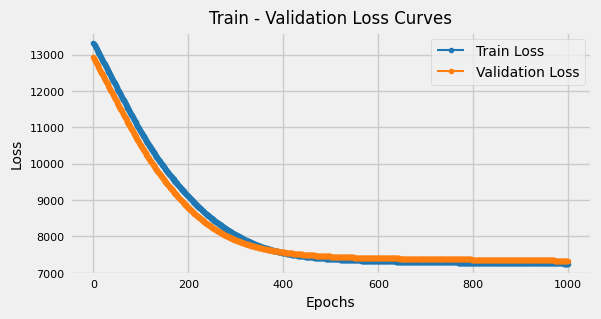

In [70]:
torch.manual_seed(42) 
model = LinearModel(in_features=X_train.shape[1], out_features=1)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
metrics = [torchmetrics.MeanAbsoluteError()]
train(experiment_name="insurance_charges", 
      model=model, 
      data=(X_train, X_test, y_train, y_test), 
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=1000)

## Classification

### Data

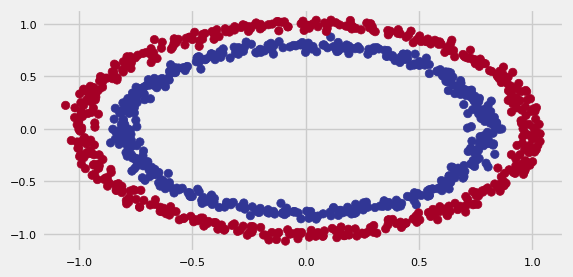

X_train: torch.Size([800, 2]) | X_test: torch.Size([200, 2]) | y_train: torch.Size([800]) | y_test: torch.Size([200])
Target Counts: (tensor([0., 1.]), tensor([400, 400])) | (tensor([0., 1.]), tensor([100, 100])) 



In [71]:
# Create data to experiment with
def make_data():
    # Make 1000 circles
    X, y = make_circles(1000, noise=0.03, random_state=42)
    
    # Create feature and target tensors
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    # Split train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Plot circles and print info
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
    plt.show()
    
    print(f"X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape}")
    print(f"Target Counts: {torch.unique(y_train, return_counts=True)} | {torch.unique(y_test, return_counts=True)} \n")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_data()

### Models

We will build our model in two ways. The sequential way and the functional way. Both ways will result to the same model, it's just different ways of developing the model. Let's start with the sequential.

#### Sequential

In [72]:
# Build model using `nn.Sequential` which accepts layers of `nn.Module` module in a sequential order
class SequentialClassifier(nn.Module):
    
    def __init__(self, in_features: int, hidden_units: int, out_features: int):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units), # Input pre-activation layer
            nn.ReLU(), # Hidden activation layer
            nn.Linear(in_features=hidden_units, out_features=hidden_units), # Hidden pre-activation layer
            nn.ReLU(), # Hidden activation layer
            nn.Linear(in_features=hidden_units, out_features=out_features), # Hidden pre-activation layer
            nn.Sigmoid() # Output activation layer
        )
       
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequential(x).squeeze()

sequential_classifier = SequentialClassifier(in_features=2, hidden_units=10, out_features=1)

In [73]:
summary(sequential_classifier, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                       Input Shape     Output Shape    Param #         Trainable
SequentialClassifier (SequentialClassifier)   [800, 2]        [800]           --              True
├─Sequential (sequential)                     [800, 2]        [800, 1]        --              True
│    └─Linear (0)                             [800, 2]        [800, 10]       30              True
│    └─ReLU (1)                               [800, 10]       [800, 10]       --              --
│    └─Linear (2)                             [800, 10]       [800, 10]       110             True
│    └─ReLU (3)                               [800, 10]       [800, 10]       --              --
│    └─Linear (4)                             [800, 10]       [800, 1]        11              True
│    └─Sigmoid (5)                            [800, 1]        [800, 1]        --              --
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input 

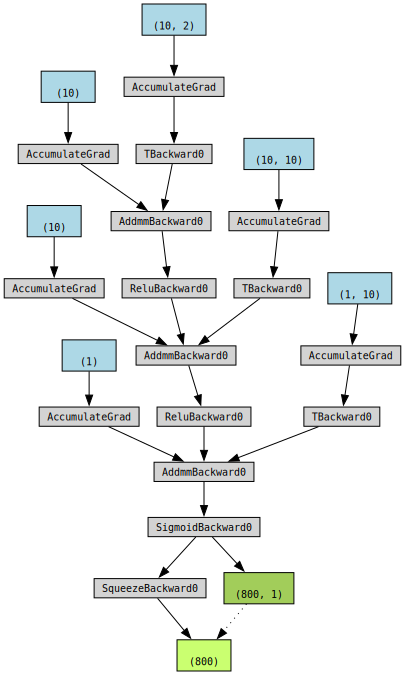

In [74]:
make_dot(sequential_classifier(X_train))

As we see, we specified the layers and instantiated the model after passing the layers to the `nn.Sequential` class. The output of the first fully connected layer is used as the input to the first `ReLU` layer. The output of the first `ReLU` layer becomes the input for the second fully connected layer. Then, the output of the second fully connected layer is used as the input to the second `ReLU` layer. Finally, the output of the second `Relu` becomes the input to the last fully connected layer and then it is passed to the `Sigmoid` function. We can further configure these layers, for example, by applying different activation functions, initializers, or regularization methods to the parameters.

#### Functional

In the previous example, we used the `Sequential` class to create a fully connected NN with multiple layers. This is a very common and convenient way of building models. However, it unfortunately doesn’t allow us to create more complex models that have multiple input, output, or intermediate branches. This is something that happens a lot. At some point in developing neural networks, we will find ourselves in a situation where we want to compute something that the premade modules do not cover. When we want to build models that do more complex things than just applying one layer after another, we need to leave `nn.Sequential` for something that gives us added flexibility. This is the functional way of building things and that’s where `nn.Module` comes in handy.

The alternative way to build complex models is by subclassing `nn.Module`. In this approach, we create a new class derived from `nn.Module` and define the method, `__init__()`, as a constructor. The `forward()` method is used to specify the forward pass. In the constructor function, `__init__()`, we define the layers as attributes of the class so that they can be accessed via the self reference attribute. Then, in the `forward()` method, we specify how these layers are to be used in the forward pass of the NN. The code for defining a new class that implements the previous model is as follows.

In [30]:
# Build model in functional way by subclassing `nn.Module`
class FunctionalClassifier(nn.Module):
    
    def __init__(self, in_features: int, hidden_units: int, out_features: int):
        super().__init__()
       
        self.input_preactivation = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.activation = nn.ReLU()
        self.hidden_layer_preactivation = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.output_pre_activation = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.output_activation = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # # Input pre-activation layer & hidden activation layer
        x = self.activation(self.input_preactivation(x))
        
        # Hidden pre-activation layer & hidden activation layer
        x = self.activation(self.hidden_layer_preactivation(x))
        
        # Hidden output pre-activation layer
        x = self.output_pre_activation(x)
        
        # Squeeze results
        x = x.squeeze()
        
        # Output activation layer
        x = self.output_activation(x)
        
        return x

functional_classifier = FunctionalClassifier(in_features=2, hidden_units=10, out_features=1)

In [75]:
summary(functional_classifier, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params", "trainable"], col_width=15, row_settings=["var_names"])

Layer (type (var_name))                       Input Shape     Output Shape    Param #         Trainable
FunctionalClassifier (FunctionalClassifier)   [800, 2]        [800]           --              True
├─Linear (input_preactivation)                [800, 2]        [800, 10]       30              True
├─ReLU (activation)                           [800, 10]       [800, 10]       --              --
├─Linear (hidden_layer_preactivation)         [800, 10]       [800, 10]       110             True
├─ReLU (activation)                           [800, 10]       [800, 10]       --              --
├─Linear (output_pre_activation)              [800, 10]       [800, 1]        11              True
├─Sigmoid (output_activation)                 [800]           [800]           --              --
Total params: 151
Trainable params: 151
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.00
Estimated Total Size (

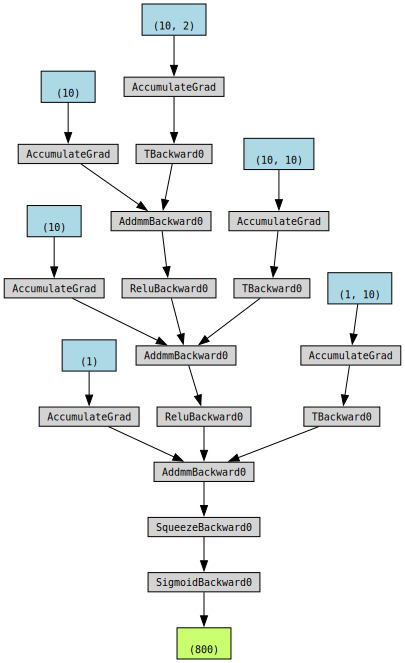

In [76]:
make_dot(functional_classifier(X_train))

In cases where we want to define a new layer that is not already supported by PyTorch, we can define a new class derived from the `nn.Module` class. This is especially useful when designing a new layer or customizing an existing layer. We will see this in action in the next notebook where we will replicate a model as described in a paper.

### Train & Validate Model

Epoch: 0 | Train Loss: 0.693 | Validation Loss: 0.693
Epoch: 200 | Train Loss: 0.690 | Validation Loss: 0.689
Epoch: 400 | Train Loss: 0.685 | Validation Loss: 0.684
Epoch: 600 | Train Loss: 0.675 | Validation Loss: 0.673
Epoch: 800 | Train Loss: 0.652 | Validation Loss: 0.648
Epoch: 1000 | Train Loss: 0.568 | Validation Loss: 0.574
Epoch: 1200 | Train Loss: 0.371 | Validation Loss: 0.406
Epoch: 1400 | Train Loss: 0.172 | Validation Loss: 0.221
Epoch: 1600 | Train Loss: 0.091 | Validation Loss: 0.127
Epoch: 1800 | Train Loss: 0.058 | Validation Loss: 0.087


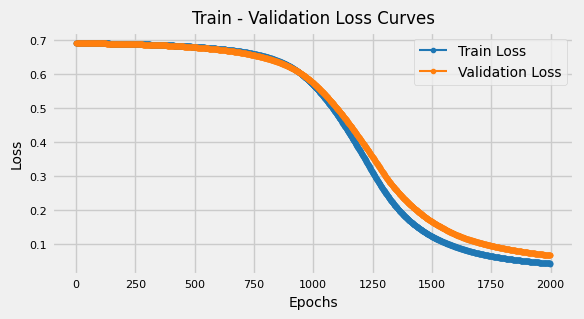

In [77]:
torch.manual_seed(42)
model = SequentialClassifier(in_features=2, hidden_units=10, out_features=1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
metrics = [torchmetrics.Accuracy("binary", num_classes=2)]
train(experiment_name="binary_classification", 
      model=model, 
      data=(X_train, X_test, y_train, y_test), 
      loss_fn=loss_fn, 
      optimizer=optimizer, 
      metrics=metrics, 
      epochs=2000)